In [20]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Set up project root path
ROOT_PATH = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(ROOT_PATH)

In [21]:
# Imports
from Models.LSTM import LSTMModel
from Training.Helper.dataPreprocessing import load_data, prepare_dataloader
from Training.Helper.PyTorchModular import loss_curve, optuna_tune_and_train
from Training.Helper.hyperparameters import load_best_hyperparameters

# File paths
train_file = os.path.join(ROOT_PATH, "Data", "Train", "train1990s.csv")
model_save_path = os.path.join(ROOT_PATH, "Models", "Weights", "LSTM")
model_name = "LSTM"
sequence_length = 48

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [22]:
# Load data (no exogenous variables)
X_train, y_train, \
X_val, y_val, \
X_test, y_test, \
dates, y_scaler = load_data(
    train_file=train_file,
    sequence_length=sequence_length,
    config={"use_exog": False}
)

# Reshape input to [batch, sequence_length, input_size=1] for LSTM
X_train = X_train.reshape(X_train.shape[0], -1, 1)
X_val = X_val.reshape(X_val.shape[0], -1, 1)

# Prepare DataLoaders
train_loader = prepare_dataloader(X_train, y_train)
val_loader   = prepare_dataloader(X_val, y_val)

# Load Optuna-tuned or fallback hyperparameters
best_params = load_best_hyperparameters() or {
    "hidden_size": 64,
    "num_layers": 2,
    "lr": 0.001
}

2025-03-29 22:37:33,992 - INFO - Added time features: year, month, quarter. DataFrame shape: (408, 372)


In [23]:
# Initialize LSTM model
model = LSTMModel(
    input_size=X_train.shape[-1],
    hidden_size=best_params["hidden_size"],
    num_layers=best_params["num_layers"],
    output_size=1
).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=best_params["lr"])
criterion = nn.MSELoss()

In [ ]:
# Train the model
model, metadata = optuna_tune_and_train(
    model_class=LSTMModel,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    max_epochs=50,
    model_save_path=model_save_path,
    model_name=model_name,
    use_best_hyperparams=False,
    n_trials=20,
    verbose=True
)

# Plot training/validation loss
loss_curve(
    metadata["trainLoss"],
    metadata["validLoss"],
    title="LSTM Training vs Validation Loss"
)

[I 2025-03-29 22:37:34,012] A new study created in memory with name: LSTM_hyperparameter_optimisation


 Running Optuna hyperparameter tuning...


[I 2025-03-29 22:37:36,549] Trial 0 finished with value: 0.3633015331482783 and parameters: {'hidden_size': 50, 'num_layers': 4, 'lr': 2.3537234071020482e-05}. Best is trial 0 with value: 0.3633015331482783.


In [ ]:
# Make predictions on test set
X_test = X_test.reshape(X_test.shape[0], -1, 1)  # Ensure correct shape
model.eval()
with torch.no_grad():
    y_pred_scaled = model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()

# Inverse scale
y_pred = y_scaler.inverse_transform(y_pred_scaled)

# Save to Predictions folder
np.save(os.path.join(ROOT_PATH, "Predictions", "LSTM.npy"), y_pred)


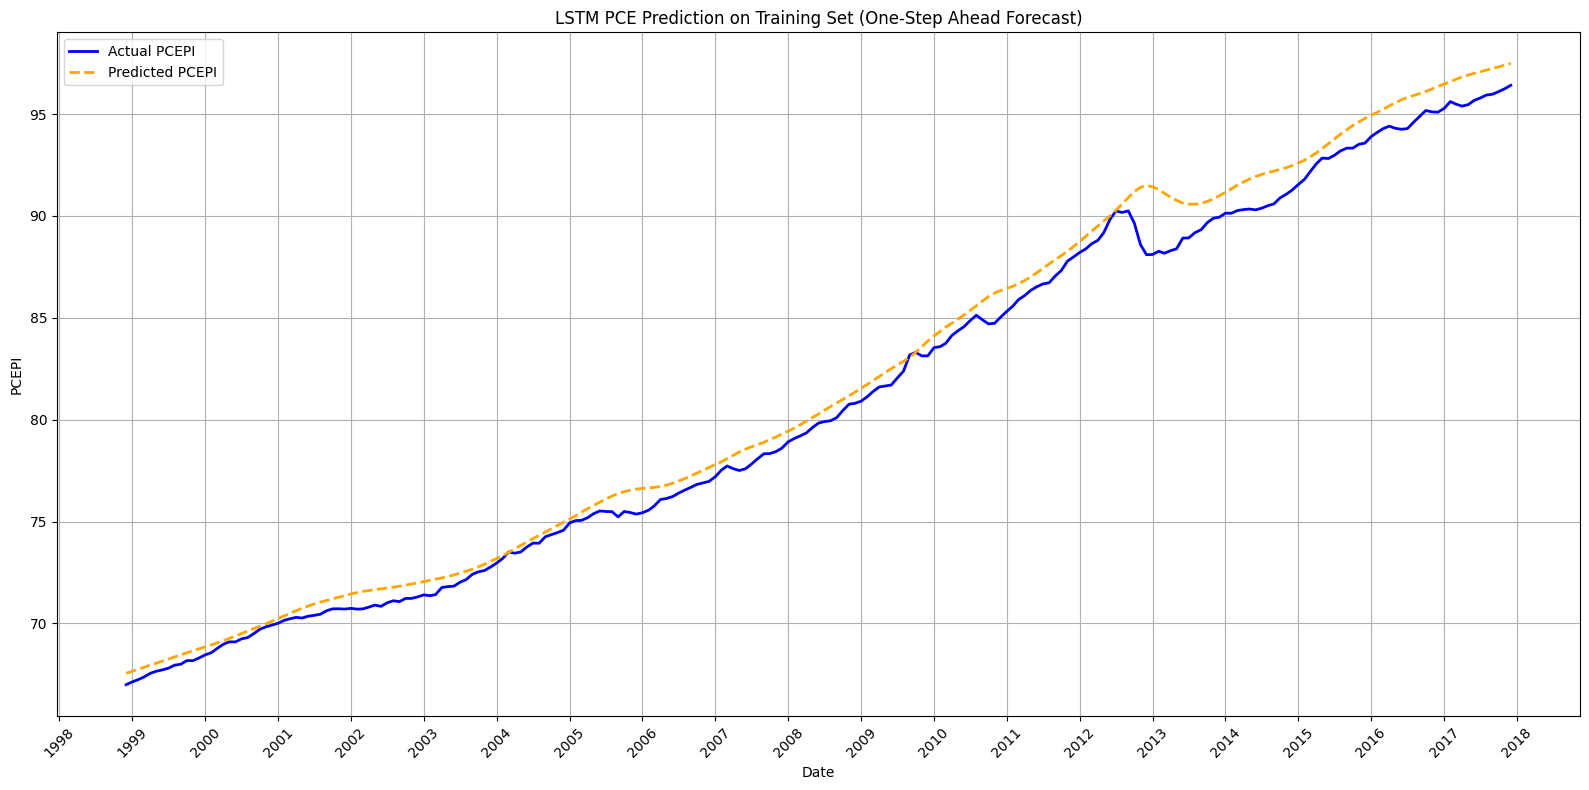

In [ ]:
# --- 1. Create sequences again from full training data (no split)
X_all = X_train.reshape(X_train.shape[0], -1, 1)
X_all_tensor = torch.tensor(X_all, dtype=torch.float32).to(device)

# --- 2. Predict on all training sequences ---
model.eval()
with torch.no_grad():
    train_preds_scaled = model(X_all_tensor).cpu().numpy()

# --- 3. Inverse transform predictions and actuals ---
train_preds = y_scaler.inverse_transform(train_preds_scaled)
train_actual = y_scaler.inverse_transform(y_train.reshape(-1, 1))

# Dates should match the prediction points
train_plot_dates = dates[sequence_length : sequence_length + len(train_preds)]

# --- 4. Plot predictions on full training range ---
plt.figure(figsize=(16, 8))
plt.plot(train_plot_dates, train_actual, label="Actual PCEPI", color="blue", linewidth=2)
plt.plot(train_plot_dates, train_preds, label="Predicted PCEPI", linestyle="--", color="orange", linewidth=2)

plt.xlabel("Date")
plt.ylabel("PCEPI")
plt.title("LSTM PCE Prediction")
plt.legend()
plt.grid(True)

# Format x-axis with readable dates
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)     

plt.tight_layout()
plt.show()